This notebook is dedicated to explore potential race-based bias in police killings, based on the Police Violence dataset.

**Assumptions:**
- The dataset is sorted by race: ["black", "hispanic", "white"]
- Colors in the plots should follow the mapping to the race: {"black": "black", "hispanic":"red", "white":"blue"}

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.rcParams['figure.dpi']= 300 #For a higher resolution of the plots

***

In [4]:
PV_data = pd.read_csv('./data/police_violence.csv', index_col=0)
PV_data.head()

,victim_age,victim_gender,victim_race,City,State,criminal_charges,victim_armed,alleged_weapon,victim_fleeing,year
6177,41.0,Male,black,Spartanburg,SC,No known charges,Allegedly Armed,knife,not fleeing,2015
2363,29.0,Male,black,Newark,NJ,No known charges,Vehicle,vehicle,car,2018
2364,37.0,Male,black,Newark,NJ,No known charges,Allegedly Armed,gun,NaN,2018
5686,28.0,Male,black,Wilmington,DE,No known charges,Allegedly Armed,gun,not fleeing,2015
2366,34.0,Male,black,Orlando,FL,No known charges,Allegedly Armed,gun,not fleeing,2018


In [5]:
total = len(PV_data)

In [6]:
races = PV_data.victim_race.unique()
colors= ["black", "red", "blue"] #the color palette for the plots

# General information

In [7]:
police_charged = len(PV_data.query('criminal_charges == "Charged"')) / total *100
print("The probability of the police getting charged of murder is: %4.2f" % police_charged)

The probability of the police getting charged of murder is: 1.90


### Distribution of races among victims armed with at least a gun:

In [8]:
df_guns = PV_data.query('alleged_weapon == "gun"')
total = len(df_guns)

In [9]:
count_guns_by_race = df_guns.groupby('victim_race').count()

for race in races:
    c = count_guns_by_race.loc[race:race, 'State'][0]
    prct = c/total * 100
    print("%4.2f percent of victims carrying a gun are %s."%(prct, race))

29.66 percent of victims carrying a gun are black.
17.07 percent of victims carrying a gun are hispanic.
53.27 percent of victims carrying a gun are white.


# Exploration of potential bias

### Race bias in criminal charges:

In [10]:
uncharged_percts = [] #uncharged percentages

for race in races:
    df = PV_data.query('victim_race == @race')
    total_victims = len(df)
    count_df = df.groupby('criminal_charges').count()
    #count_uncharged is the count of cases where the police didn't get criminal charges for the murder
    count_uncharged = count_df.loc['No known charges':'No known charges', 'State'][0] #we use the column `State` to do the slicing because it has zero NaN values. 
    
    uncharged_percent = np.around(count_uncharged / total_victims * 100)
    uncharged_percts.append(uncharged_percent)
    print("Percentage of police not being charged in case of a %s victim: %4.2f"%(race, uncharged_percent))

Percentage of police not being charged in case of a black victim: 97.00
Percentage of police not being charged in case of a hispanic victim: 99.00
Percentage of police not being charged in case of a white victim: 99.00


### Race bias in killing when the victim is unarmed (or unclear):

In [11]:
unarmed_percts = [] #percentages of being killed while unarmed

for race in races:
    df = PV_data.query('victim_race == @race')
    total_victims = len(df)
    count_df = df.groupby('victim_armed').count()
    count_unarmed = count_df.loc['Unarmed':'Unarmed', 'State'][0] #count_unarmed is the number of unarmed victims
    count_unclear = count_df.loc['Unclear':'Unclear', 'State'][0] #count_unclear is the number of cases where it was unclear if the victim was armed
                                                                  #we use the column `State` to do the slicing because it has zero NaN values. 
    killing_percent = np.around((count_unarmed+count_unclear) / total_victims * 100)
    unarmed_percts.append(killing_percent)
    print("Percentage of being killed while unarmed (or unclear) in case of a %s victim: %4.2f"%(race, killing_percent))

Percentage of being killed while unarmed (or unclear) in case of a black victim: 24.00
Percentage of being killed while unarmed (or unclear) in case of a hispanic victim: 25.00
Percentage of being killed while unarmed (or unclear) in case of a white victim: 20.00


### Race bias in killing based on victim fleeing or not:

In [12]:
not_fleeing_percts = [] #percentages of being killed while not fleeing
for race in races:
    df = PV_data.query('victim_race == @race')
    total_victims = len(df)
    count_df = df.groupby('victim_fleeing').count()
    count_not_fleeing = count_df.loc['not fleeing':'not fleeing', 'State'][0] #count_not_fleeing is the count of victims who were not fleeing the police in the time of the murder
                                                                              #we use the column `State` to do the slicing because it has zero NaN values. 

    killing_percent = np.around(count_not_fleeing / total_victims * 100, decimals=2)
    not_fleeing_percts.append(killing_percent)
    print("Percentage of being killed while not fleeing in case of a %s victim: %4.2f"%(race, killing_percent))

Percentage of being killed while not fleeing in case of a black victim: 40.13
Percentage of being killed while not fleeing in case of a hispanic victim: 43.18
Percentage of being killed while not fleeing in case of a white victim: 48.42


***

# Plots

### Police charged, victim unarmed (or unclear), victim not fleeing

In [13]:
white_info = [uncharged_percts[0], unarmed_percts[0], not_fleeing_percts[0]]
black_info = [uncharged_percts[1], unarmed_percts[1], not_fleeing_percts[1]]
hisp_info = [uncharged_percts[2], unarmed_percts[2], not_fleeing_percts[2]]

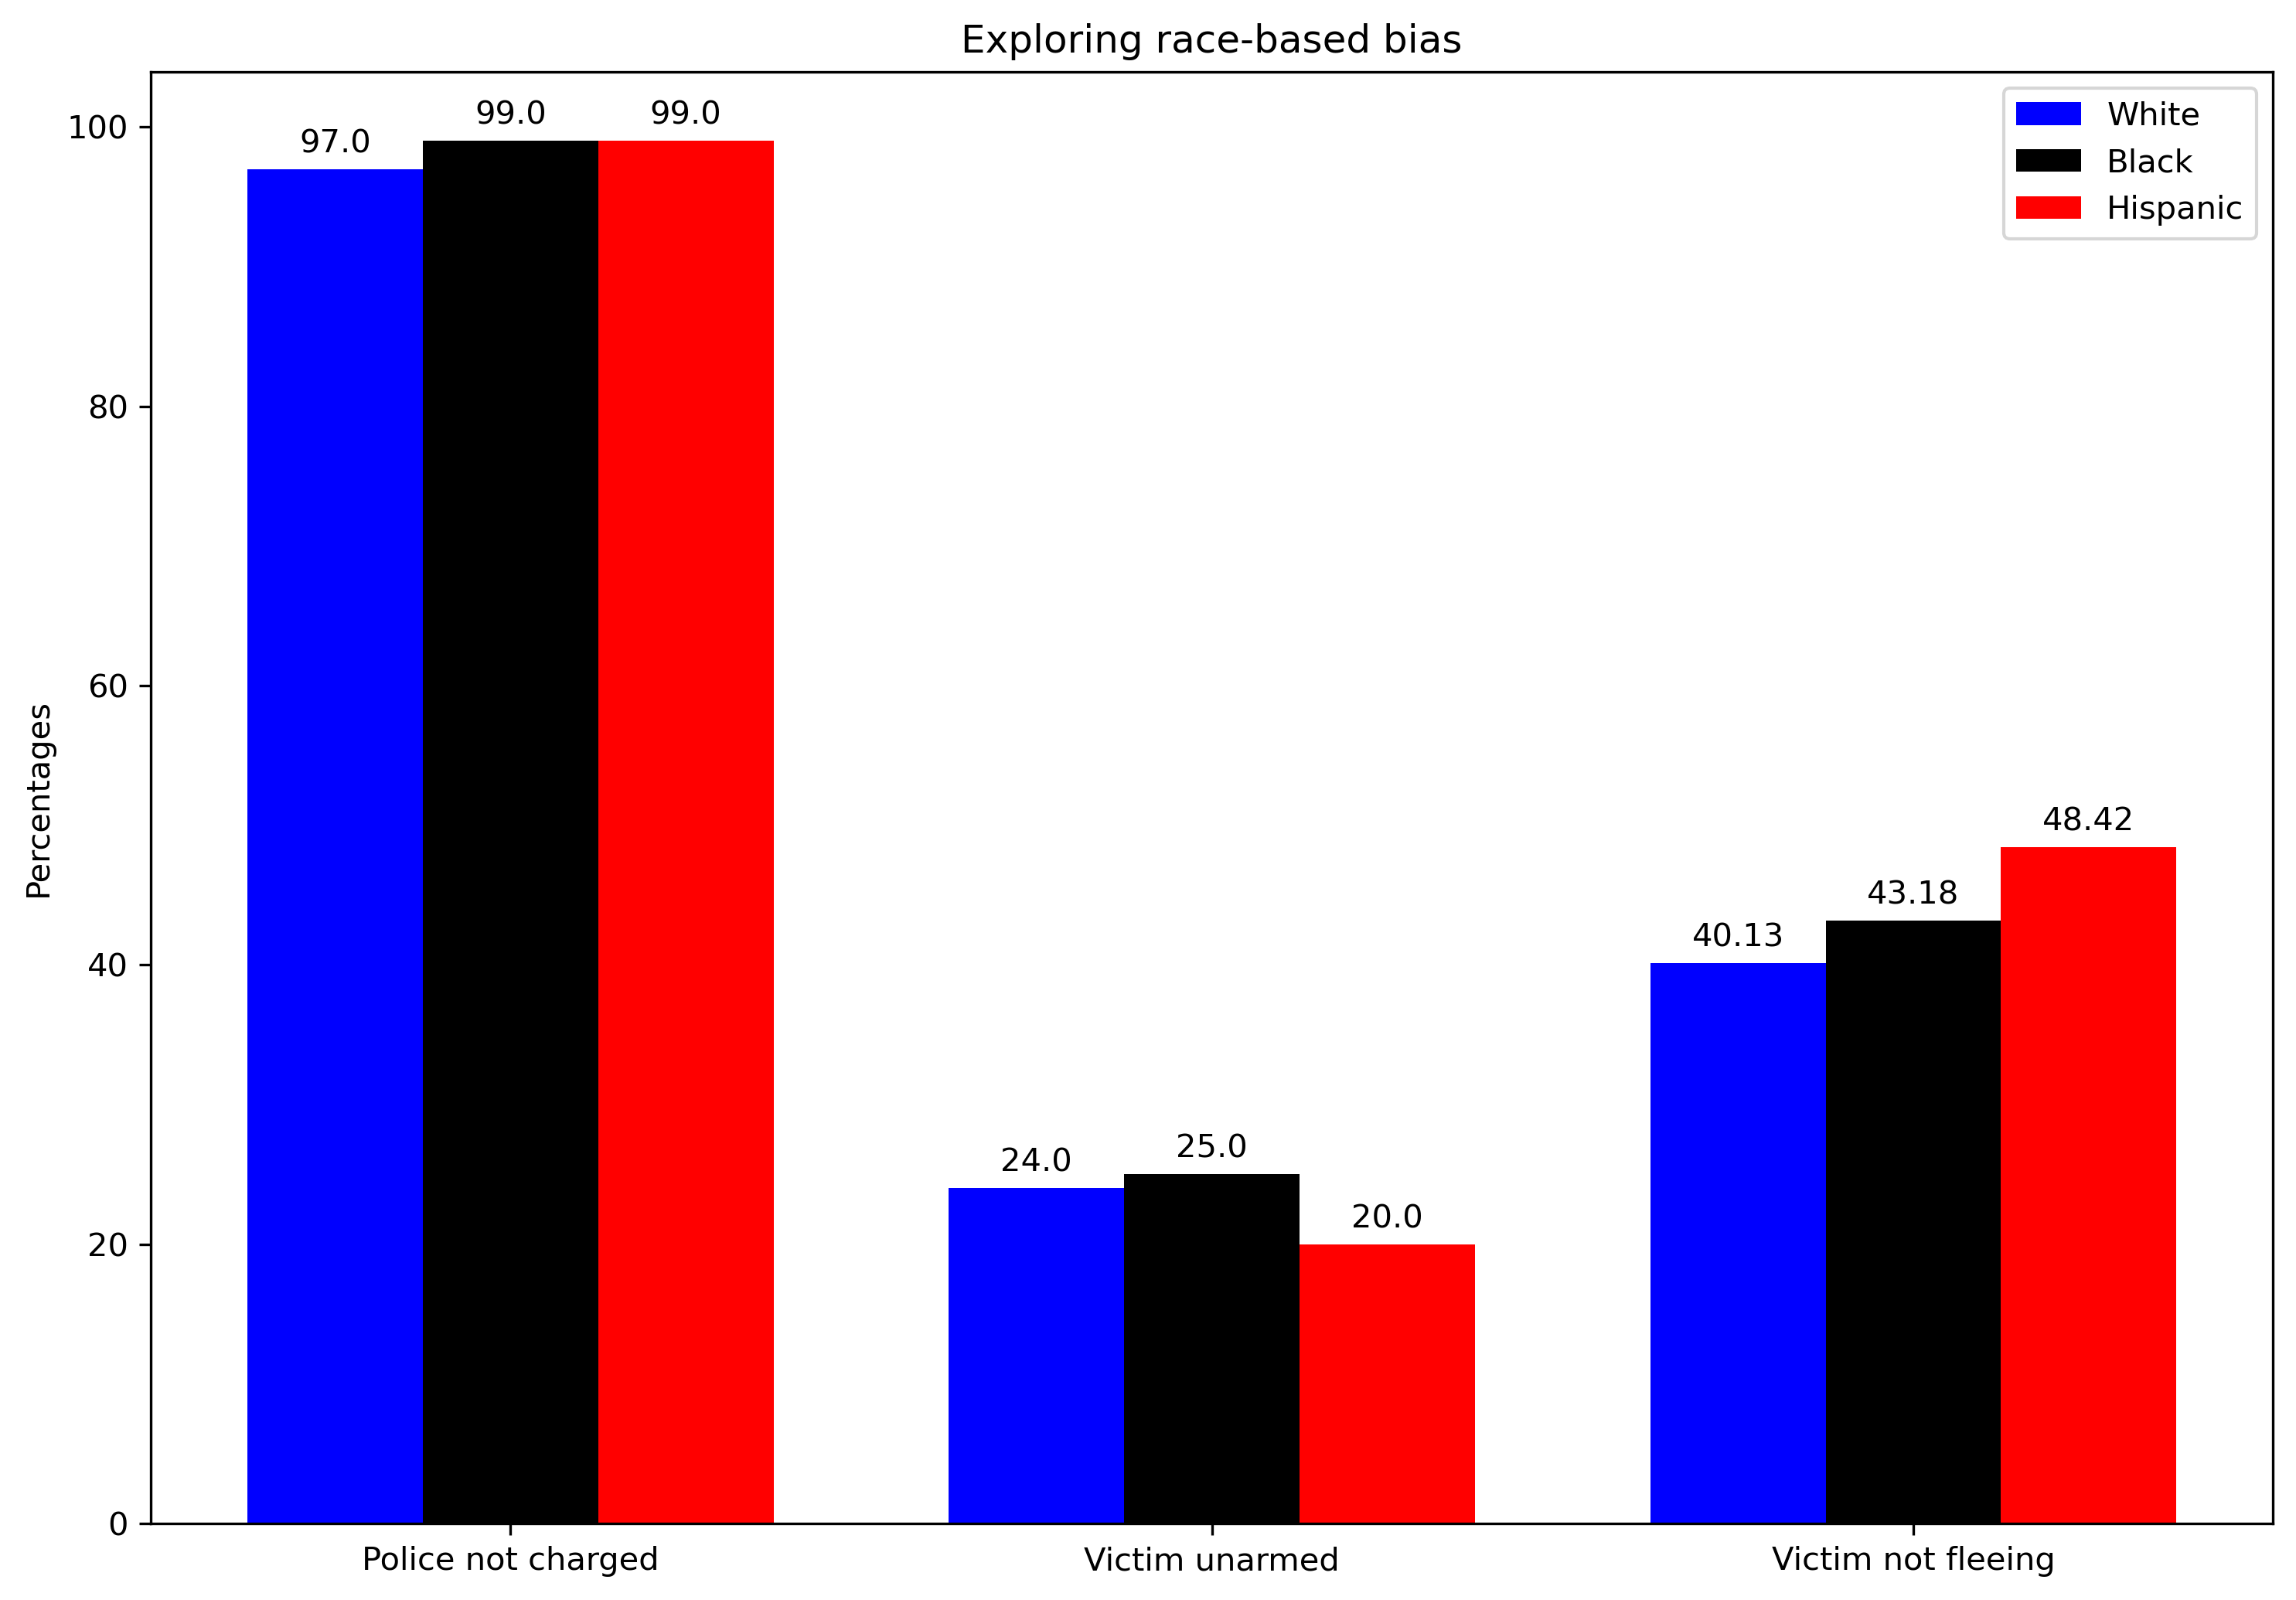

In [14]:
categories = ['Police not charged', 'Victim unarmed', 'Victim not fleeing']

x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

cat1 = ax.bar(x - width, white_info, width, label='White', color="blue")
cat2 = ax.bar(x, black_info, width, label='Black', color="black")
cat3 = ax.bar(x + width, hisp_info, width, label='Hispanic', color="red")

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(cat1)
autolabel(cat2)
autolabel(cat3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentages')
ax.set_title('Exploring race-based bias')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()


fig.tight_layout()

fig = plt.gcf()
plt.show()
fig.savefig('./plots/barplot.png')

***

In [15]:
"""total_df: Dataframe representing the total_count of victims per race, each year"""

total_df = PV_data.groupby(['victim_race', 'year'], as_index=False).count()
total_df['total_count'] = total_df.State #We use `State` in the splitting because it doesn't contain any NaN values, so the count is correct
total_df = total_df[['victim_race', 'year', 'total_count']]
total_df.head()

,victim_race,year,total_count
0,black,2013,287
1,black,2014,277
2,black,2015,305
3,black,2016,279
4,black,2017,276


**Comparison between races in the number of unarmed victims, over time**

In [16]:
"""unarmed_df: Dataframe representing the number of victims unarmed in every race, per year"""

unarmed_df = PV_data.query('victim_armed in ["Unarmed", "Unclear"]')
unarmed_df = unarmed_df.groupby(['victim_race', 'year', 'victim_armed'], as_index=False).count()
unarmed_df = unarmed_df.groupby(['victim_race', 'year'], as_index=False).sum()
unarmed_df['unarmed_count'] = unarmed_df.State
unarmed_df.head()

,victim_race,year,victim_age,victim_gender,City,State,criminal_charges,alleged_weapon,victim_fleeing,unarmed_count
0,black,2013,82,82,82,82,82,82,1,82
1,black,2014,95,95,95,95,95,95,0,95
2,black,2015,87,87,87,87,87,87,56,87
3,black,2016,71,72,72,72,72,72,72,72
4,black,2017,60,60,60,60,60,60,60,60


In [17]:
unarmed_df = pd.merge(total_df, unarmed_df, on=['victim_race', 'year'])
unarmed_df['%_unarmed'] = np.around(unarmed_df.unarmed_count / unarmed_df.total_count * 100, decimals=2)
unarmed_df = unarmed_df[['victim_race', 'year', '%_unarmed']]
unarmed_df.head()

,victim_race,year,%_unarmed
0,black,2013,28.57
1,black,2014,34.30
2,black,2015,28.52
3,black,2016,25.81
4,black,2017,21.74


Text(0, 0.5, '% of unarmed victims')

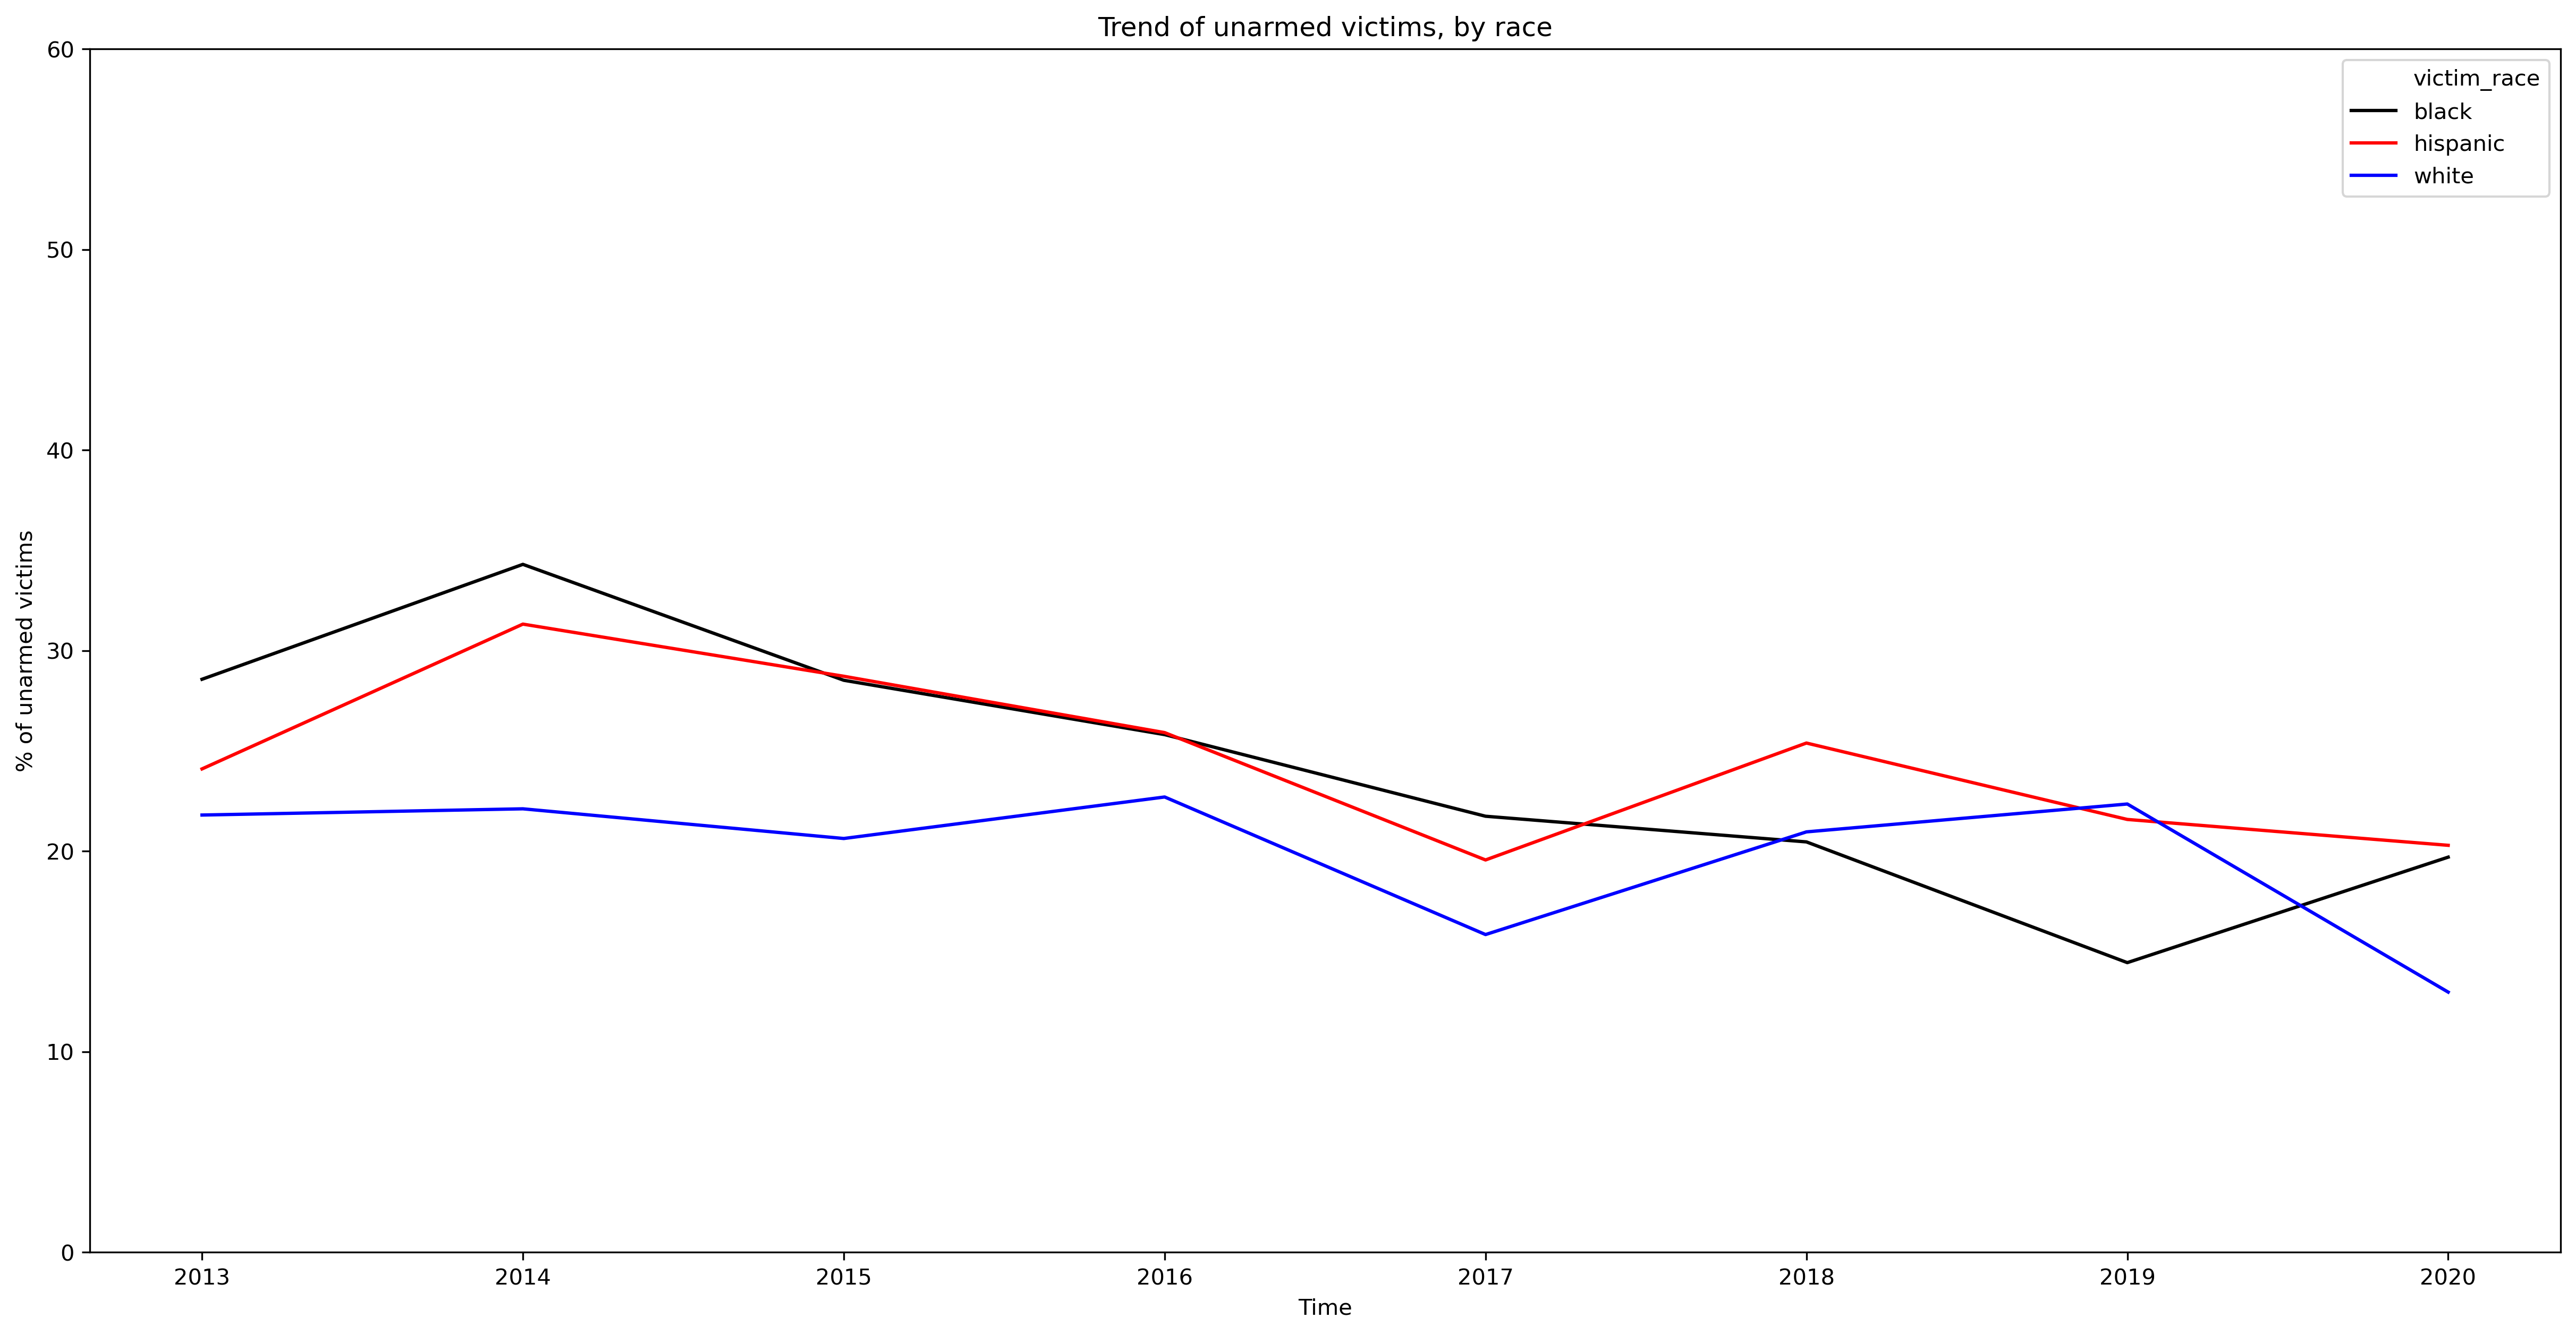

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

sns.lineplot(data=unarmed_df, x="year", y="%_unarmed", hue="victim_race", palette=colors)

ax.set_ylim(0, 60)

ax.set_title("Trend of unarmed victims, by race")
ax.set_xlabel("Time")
ax.set_ylabel("% of unarmed victims")

**Comparison between races in the number of victims carrying a gun**

In [19]:
"""group by race, year and weapon => get the number of victims carrying a gun, each year, in every race"""

guns_df = PV_data.query('alleged_weapon == "gun"')
guns_df = guns_df.groupby(['victim_race', 'year'], as_index=False).count()
guns_df['gun_count'] = guns_df.alleged_weapon
guns_df = guns_df[['victim_race', 'year', 'gun_count']]
guns_df.head()

,victim_race,year,gun_count
0,black,2013,145
1,black,2014,124
2,black,2015,149
3,black,2016,158
4,black,2017,156


In [20]:
guns_df = pd.merge(total_df, guns_df, on=['victim_race', 'year'])
guns_df['%_carrying_gun'] = np.around(guns_df.gun_count / guns_df.total_count * 100, decimals=2)
guns_df.head()

,victim_race,year,total_count,gun_count,%_carrying_gun
0,black,2013,287,145,50.52
1,black,2014,277,124,44.77
2,black,2015,305,149,48.85
3,black,2016,279,158,56.63
4,black,2017,276,156,56.52


Text(0, 0.5, '% of victims carrying a gun')

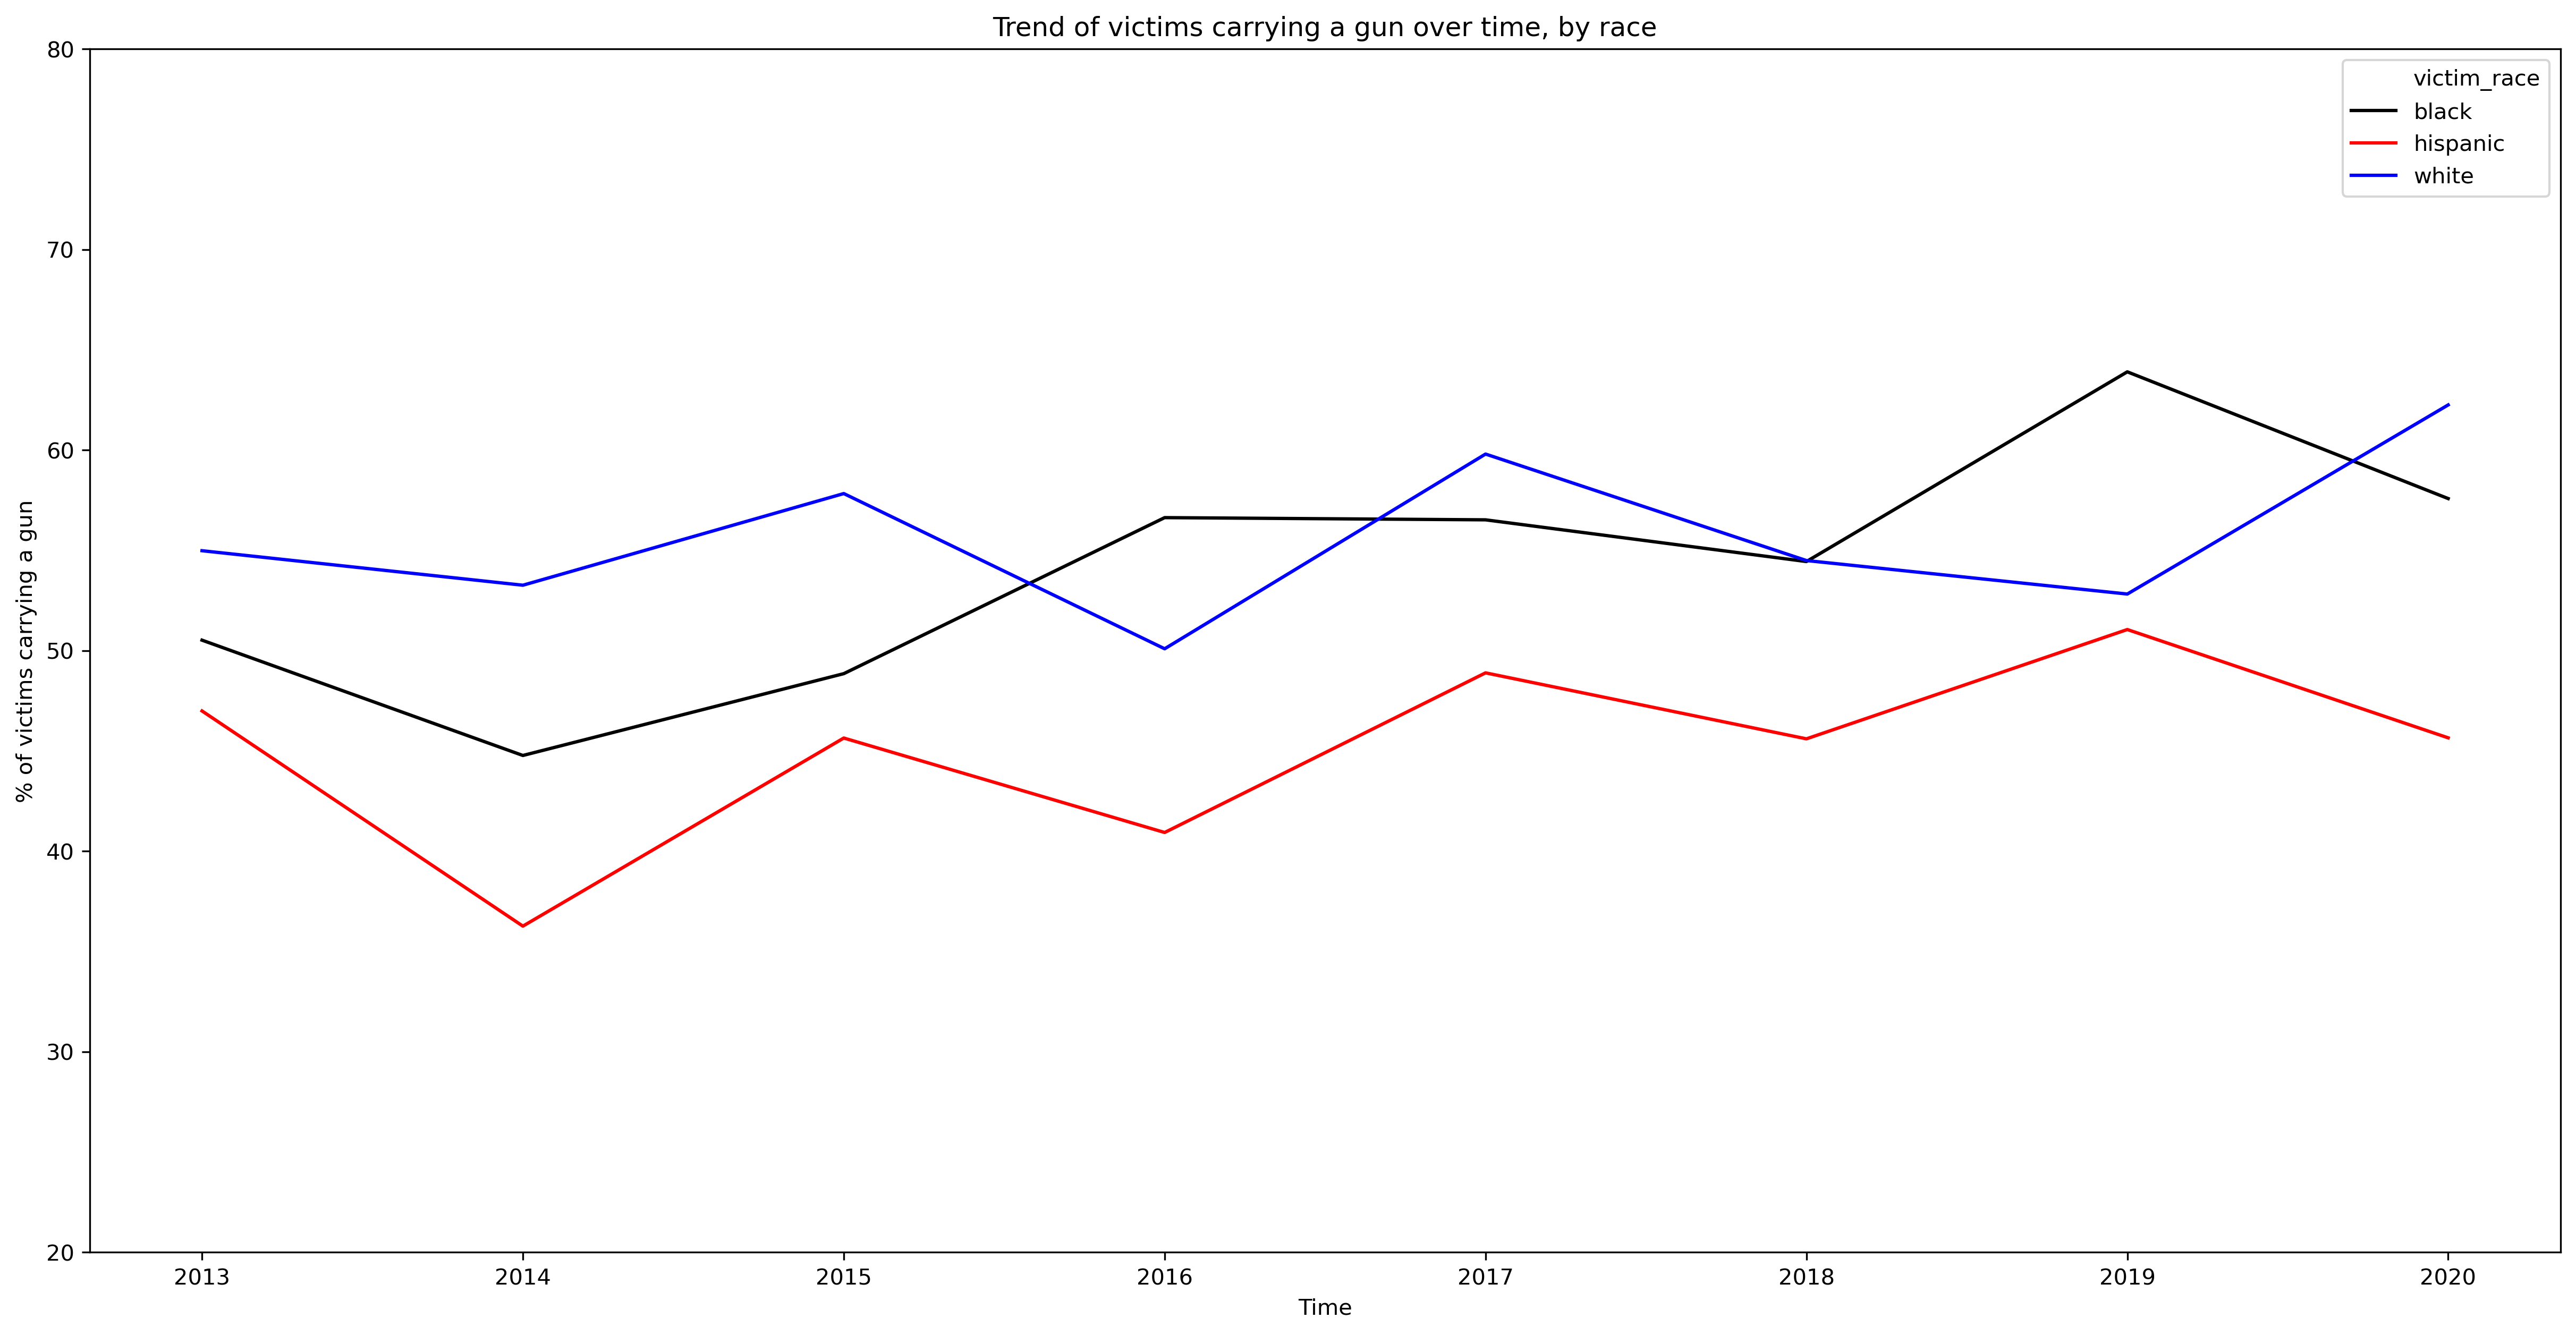

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

sns.lineplot(data=guns_df, x="year", y="%_carrying_gun", hue="victim_race", palette=colors)

ax.set_ylim(20,80)

ax.set_title("Trend of victims carrying a gun over time, by race")
ax.set_xlabel("Time")
ax.set_ylabel("% of victims carrying a gun")


**Comparison between races in the number of victims not fleeing the police when killed**

In [22]:
"""group by race, year and victim_fleeing => get the number of victims not_fleeing, each year, in every race"""

flee_df = PV_data.query('victim_fleeing == "not fleeing"')
flee_df = flee_df.groupby(['victim_race', 'year'], as_index=False).count()
flee_df['not_fleeing_count'] = flee_df.victim_fleeing
flee_df = flee_df[['victim_race', 'year', 'not_fleeing_count']]
flee_df.head()

,victim_race,year,not_fleeing_count
0,black,2013,1
1,black,2014,1
2,black,2015,175
3,black,2016,172
4,black,2017,173


In [23]:
flee_df = pd.merge(total_df, flee_df, on=['victim_race', 'year'])
flee_df['%_not_fleeing'] = np.around(flee_df.not_fleeing_count / flee_df.total_count * 100, decimals=2)
flee_df = flee_df[['victim_race', 'year', '%_not_fleeing']]
flee_df.head()

,victim_race,year,%_not_fleeing
0,black,2013,0.35
1,black,2014,0.36
2,black,2015,57.38
3,black,2016,61.65
4,black,2017,62.68


Text(0, 0.5, '% of victims not fleeing')

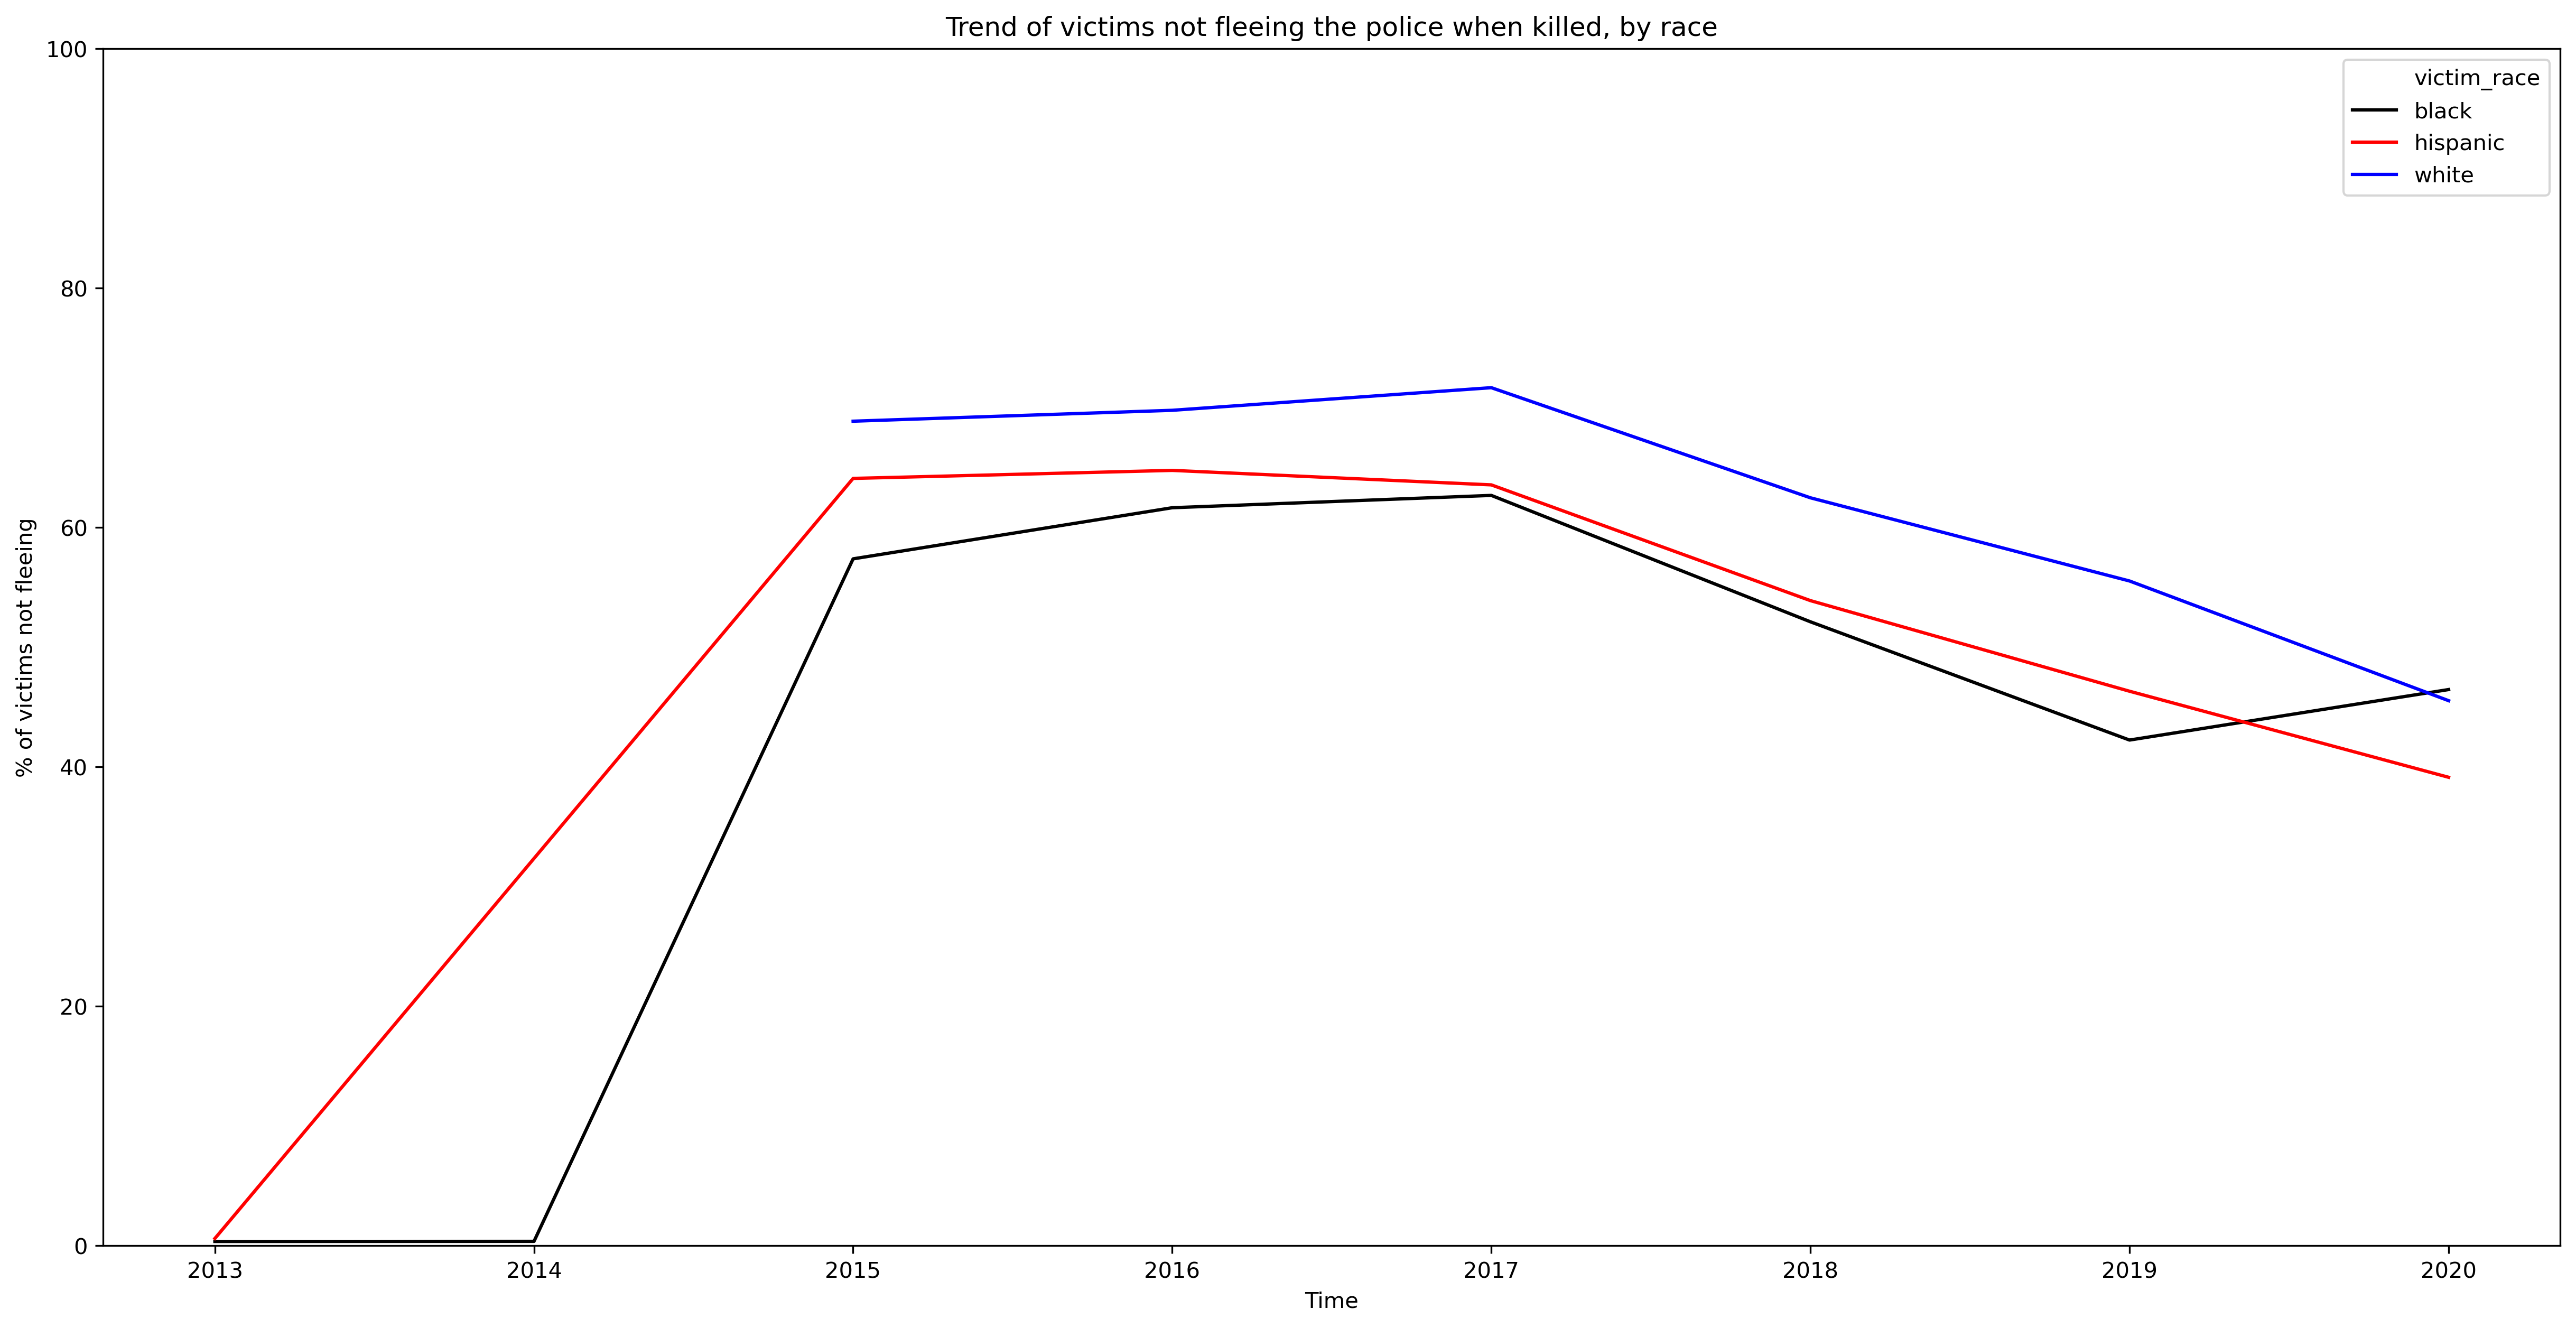

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

sns.lineplot(data=flee_df, x="year", y="%_not_fleeing", hue="victim_race", palette=colors)

ax.set_ylim(0, 100)

ax.set_title("Trend of victims not fleeing the police when killed, by race")
ax.set_xlabel("Time")
ax.set_ylabel("% of victims not fleeing")


***

**Comparison between races in the probability their murderer gets sentenced , between 2013 and 2020**

In [25]:
#group by race, year and criminal_charges => get the number of police charged, each year, in every race
charged_df = PV_data.query('criminal_charges == "Charged"')
charged_df = charged_df.groupby(['victim_race', 'year', 'criminal_charges'], as_index=False).count()
charged_df['charged_count'] = charged_df.State
charged_df.head()

,victim_race,year,criminal_charges,victim_age,victim_gender,City,State,victim_armed,alleged_weapon,victim_fleeing,charged_count
0,black,2013,Charged,10,10,10,10,10,10,0,10
1,black,2014,Charged,10,10,10,10,10,10,0,10
2,black,2015,Charged,12,12,12,12,12,12,8,12
3,black,2016,Charged,9,9,9,9,9,9,9,9
4,black,2017,Charged,7,7,7,7,7,7,7,7


In [26]:
charged_df = pd.merge(total_df, charged_df, on=['victim_race', 'year'])
charged_df['%_charged'] = np.around(charged_df.charged_count / charged_df.total_count * 100, decimals=2)
charged_df = charged_df[['victim_race', 'year', '%_charged']]
charged_df.head()

,victim_race,year,%_charged
0,black,2013,3.48
1,black,2014,3.61
2,black,2015,3.93
3,black,2016,3.23
4,black,2017,2.54


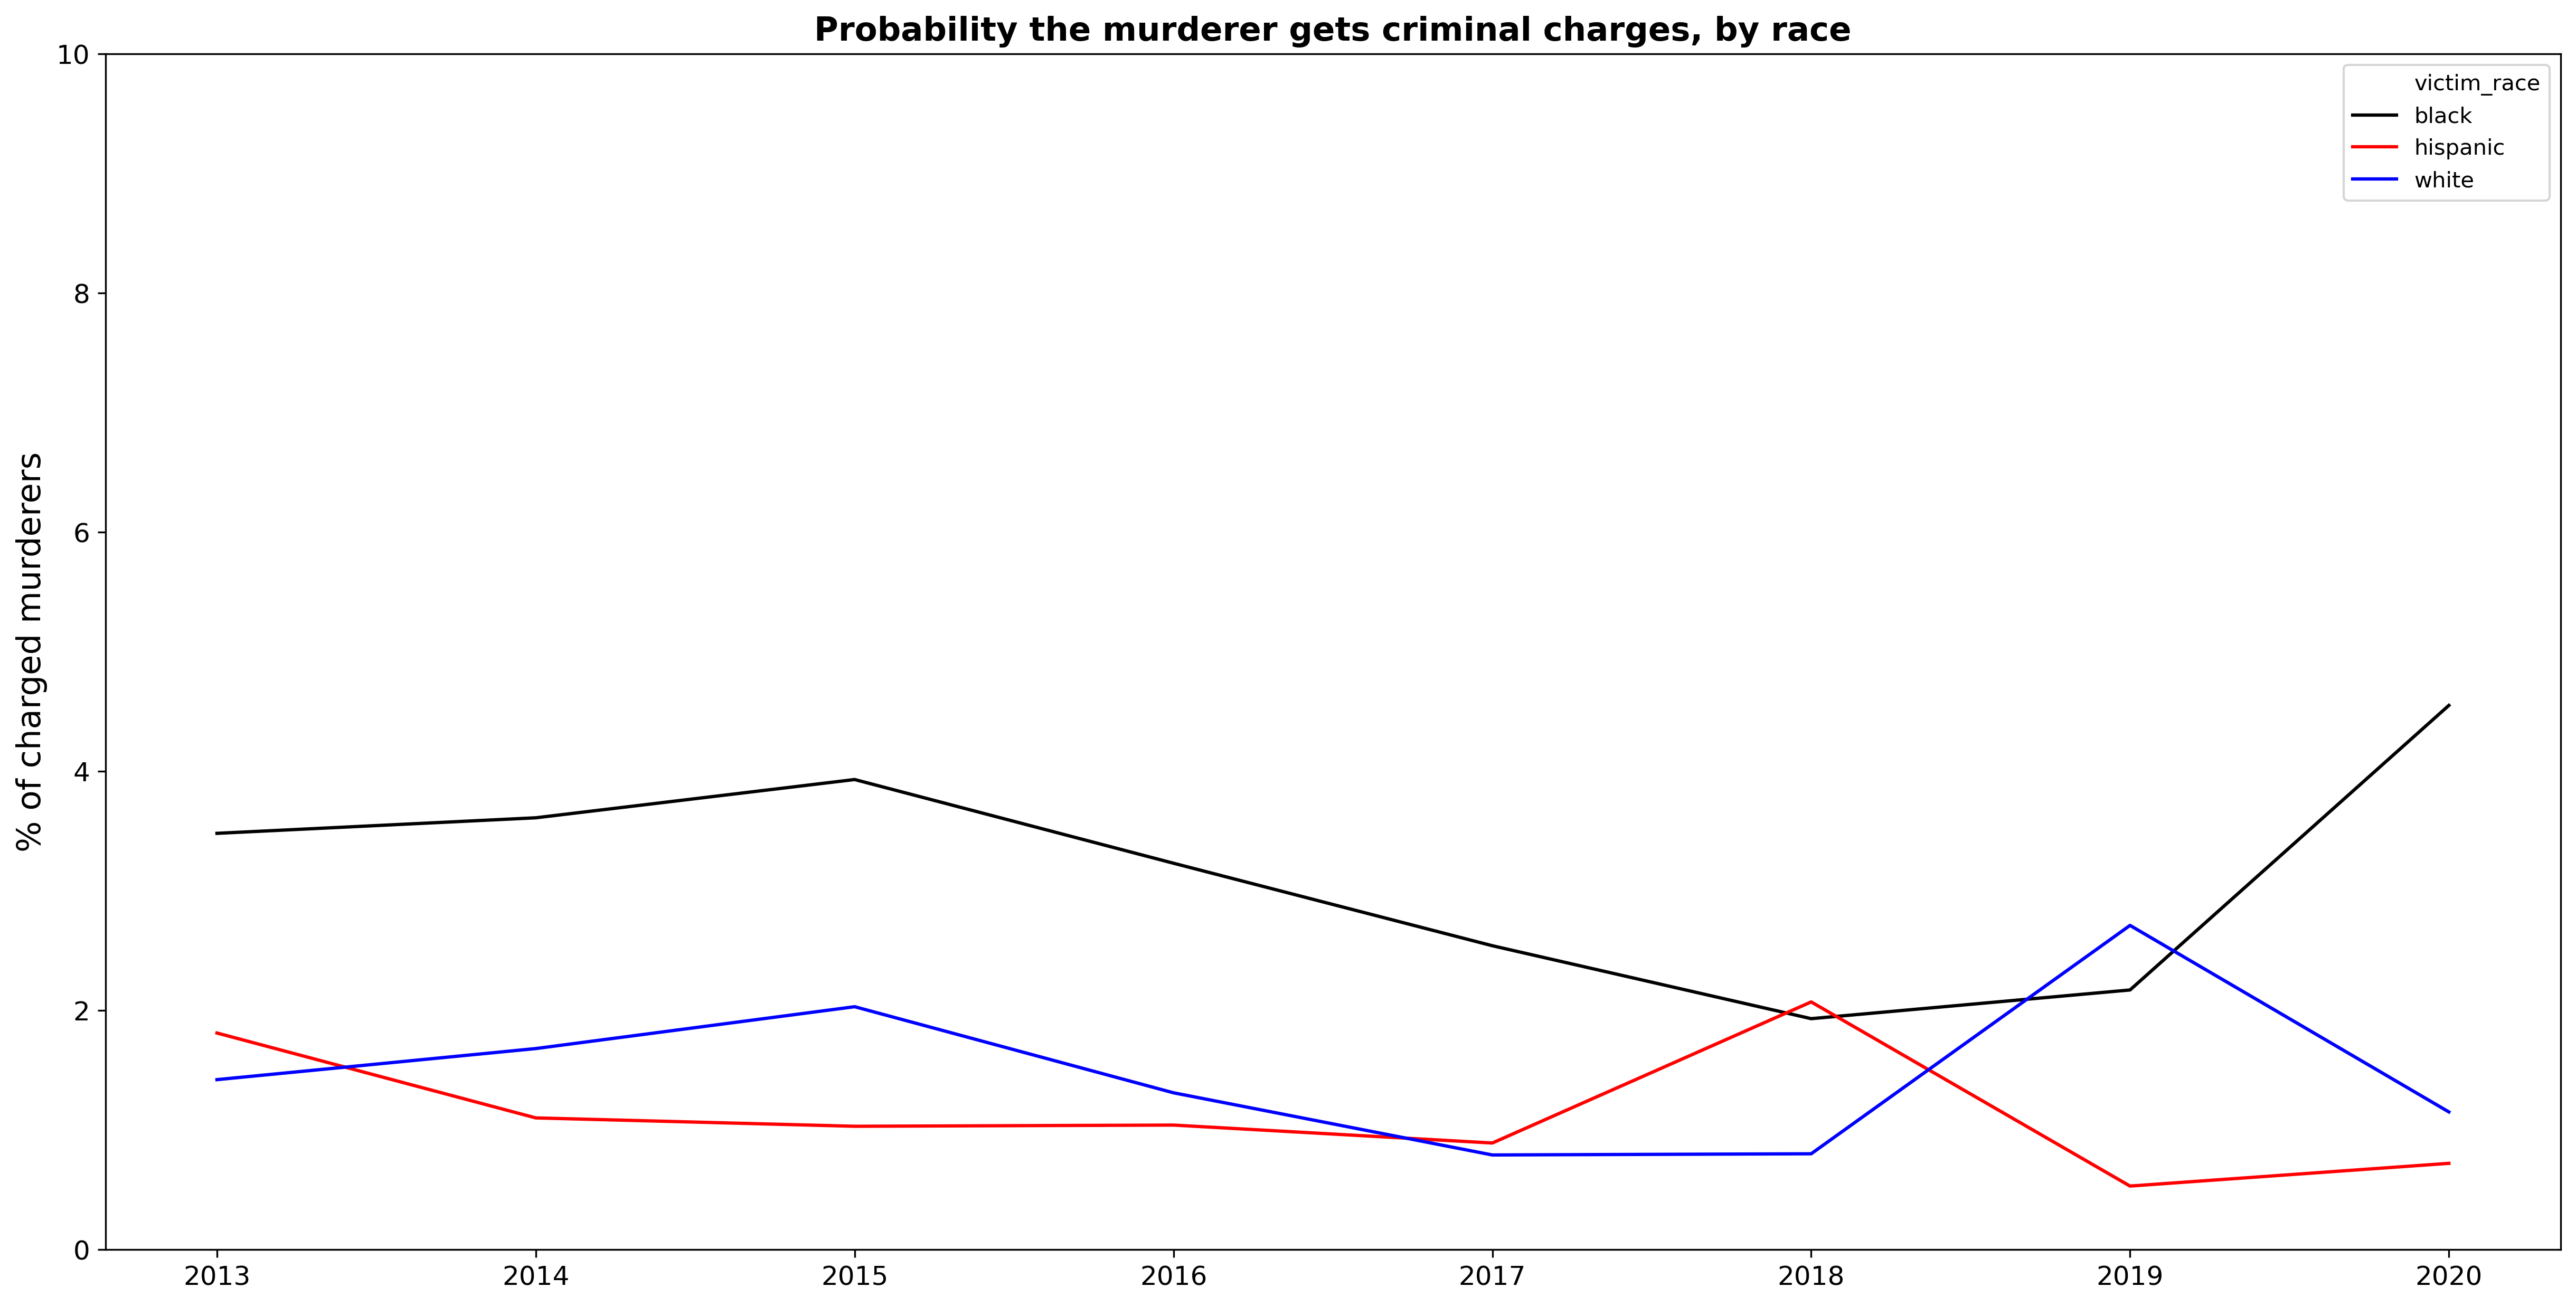

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

sns.lineplot(data=charged_df, x="year", y="%_charged", hue="victim_race", palette=["black", "red", "blue"])

ax.set_ylim(0, 10)

ax.set_title("Probability the murderer gets criminal charges, by race", fontsize=15, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel("% of charged murderers", fontsize=15)

for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)
        
for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)

fig = plt.gcf()
plt.show()
fig.savefig('./plots/charges.png')